# Deep Convolutional GAN (DCGAN)

### Goal
In this notebook, you're going to create another GAN using the MNIST dataset. You will implement a Deep Convolutional GAN (DCGAN), a very successful and influential GAN model developed in 2015.

*Note: [here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested! It might look dense now, but soon you'll be able to understand many parts of it :)*

### Learning Objectives
1.   Get hands-on experience making a widely used GAN: Deep Convolutional GAN (DCGAN).
2.   Train a powerful generative model.


![Generator architecture](Images/dcgan-gen.png)

Figure: Architectural drawing of a generator from DCGAN from [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf).

## Getting Started

#### DCGAN
Here are the main features of DCGAN (don't worry about memorizing these, you will be guided through the implementation!): 

<!-- ```
Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
• Use BatchNorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
``` -->


*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

You will begin by importing some useful packages and data that will help you create your GAN. You are also provided a visualizer function to help see the images your GAN will create.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor, num_images = 25, size = (1, 28, 28)):
    '''
    Fuction for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow = 5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    
    return

## Generator
The first component you will make is the generator. You may notice that instead of passing in the image dimension, you will pass the number of image channels to the generator. This is because with DCGAN, you use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

You will build a generator using 4 layers (3 hidden layers + 1 output layer). As before, you will need to write a function to create a single block for the generator's neural network.
<!-- From the paper, we know to "[u]se batchnorm in both the generator and the discriminator" and "[u]se ReLU activation in generator for all layers except for the output, which uses Tanh." --> 
Since in DCGAN the activation function will be different for the output layer, you will need to check what layer is being created. You are supplied with some tests following the code cell so you can see if you're on the right track!

At the end of the generator class, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network. You are also given a function to create a noise vector. These functions are the same as the ones from the last assignment.

<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_gen_block</font></code></b>
</font>
</summary>

1. You'll find [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) and [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) useful!
</details>

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
                 (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim = 10, im_chan = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            self.make_gen_block(input_channels = z_dim, output_channels = hidden_dim * 4),
            self.make_gen_block(input_channels = hidden_dim * 4, output_channels = hidden_dim * 2, 
                                kernel_size = 4, stride = 1), 
            self.make_gen_block(input_channels = hidden_dim * 2, output_channels = hidden_dim),
            self.make_gen_block(input_channels = hidden_dim, output_channels = im_chan, 
                                kernel_size = 4, final_layer = True)
        )
        
        return
    
    def make_gen_block(self, input_channels, output_channels, kernel_size = 3, stride = 2,
                       final_layer = False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), 
        and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to  (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                         (affects activation and batchnorm)
        '''

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels = input_channels, out_channels = output_channels, 
                kernel_size = kernel_size, stride = stride),
                nn.BatchNorm2d(num_features = output_channels),
                nn.ReLU(inplace = True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels = input_channels, out_channels = output_channels,
                kernel_size = kernel_size, stride = stride),
                nn.Tanh()
            )
    
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''

        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''

        x = self.unsqueeze_noise(noise)

        return self.gen(x)

In [4]:
def get_noise(n_samples, z_dim, device = 'cpu'):
    '''
    Function for creating a noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''

    return torch.randn(n_samples, z_dim, device = device)

## Discriminator
The second component you need to create is the discriminator.

You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator.
<!-- From the paper, we know that we need to "[u]se LeakyReLU activation in the discriminator for all layers." And for the LeakyReLUs, "the slope of the leak was set to 0.2" in DCGAN. -->
There are also tests at the end for you to use.
<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_disc_block</font></code></b>
</font>
</summary>

1. You'll find [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html), [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html), and [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) useful!
</details>

In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
                 (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan = 1, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(input_channels = im_chan, output_channels = hidden_dim),
            self.make_disc_block(input_channels = hidden_dim, output_channels = hidden_dim * 2),
            self.make_disc_block(input_channels = hidden_dim * 2, output_channels = 1, final_layer = True)
        )

        return

    def make_disc_block(self, input_channels, output_channels, kernel_size = 4, stride = 2, final_layer = False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                         (affects activation and batchnorm)
        ''' 

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels = input_channels, out_channels = output_channels,
                          kernel_size = kernel_size, stride = stride),
                nn.BatchNorm2d(num_features = output_channels),
                nn.LeakyReLU(negative_slope = 0.2, inplace = True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels = input_channels, out_channels = output_channels,
                          kernel_size = kernel_size, stride = stride)
            )
        
    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''

        disc_pred = self.disc(image)

        return disc_pred.view(len(disc_pred), -1)

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training
Now you can put it all together!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->


In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

# parameters to optimizer's momentum
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# transform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataloader = DataLoader(
    MNIST('.', download = True, transform = transform), 
          batch_size = batch_size, shuffle = True
)

Then, you can initialize your generator, discriminator, and optimizers.

In [8]:
gen = Generator(z_dim).to(device = device)
gen_opt = torch.optim.Adam(params = gen.parameters(), lr = lr, betas = (beta_1, beta_2))
disc = Discriminator().to(device = device)
disc_opt = torch.optim.Adam(params = disc.parameters(), lr = lr, betas = (beta_1, beta_2))

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(tensor = m.weight, mean = 0.0, std = 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(tensor = m.weight, mean = 0.0, std = 0.02)
        torch.nn.init.constant_(tensor = m.bias, val = 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, you can train your GAN!
For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. You might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse: 
![MNIST Digits Progression](images/mnist-dcgan-progression.png)


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.9334150066375734, discriminator loss: 0.5240231850743293


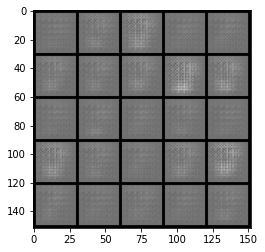

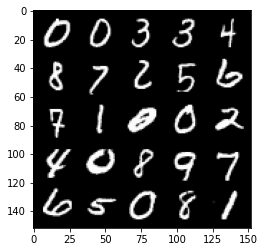

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 2.3133914976119963, discriminator loss: 0.17647307358682163


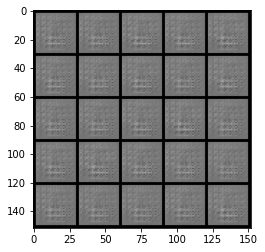

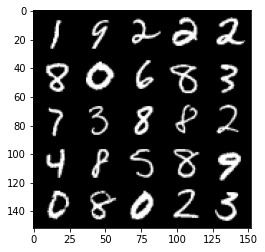

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 3.529131698608399, discriminator loss: 0.047352654121816204


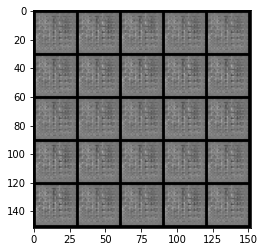

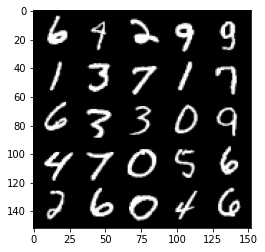

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 2.682290614917873, discriminator loss: 0.24780356824398045


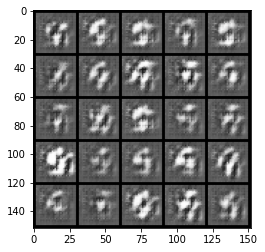

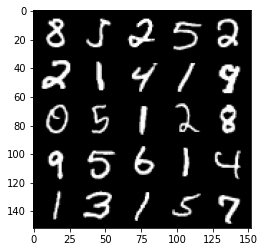

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.6548603887557978, discriminator loss: 0.40779932630062127


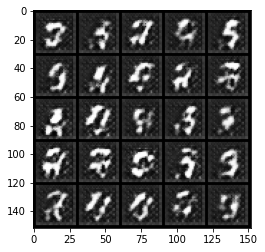

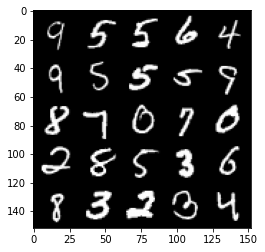

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.2337432216554898, discriminator loss: 0.5062496173977856


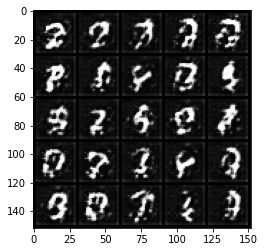

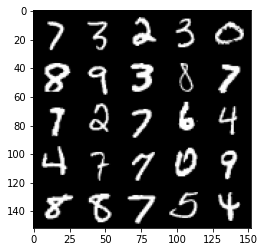

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 1.0196596118509775, discriminator loss: 0.5521478074789052


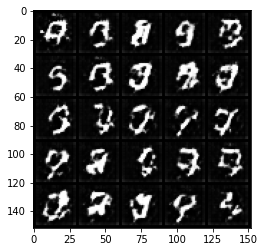

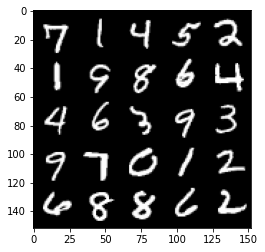

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.9214972081780437, discriminator loss: 0.580806818366051


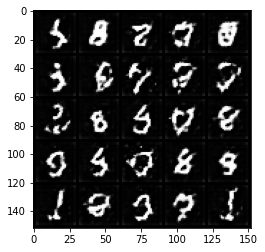

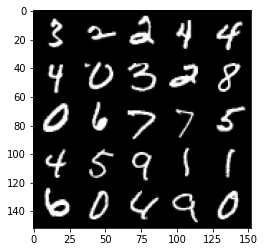

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.874736891567707, discriminator loss: 0.6037452772855759


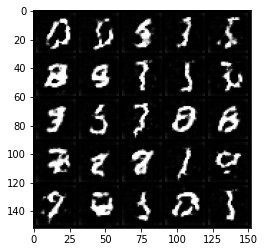

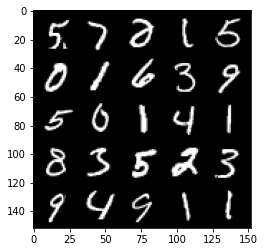

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.8260244497656823, discriminator loss: 0.6331265113353727


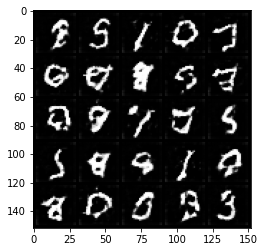

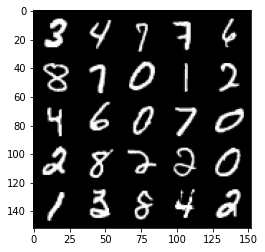

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.795892777025699, discriminator loss: 0.6554512193202978


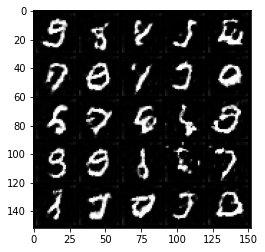

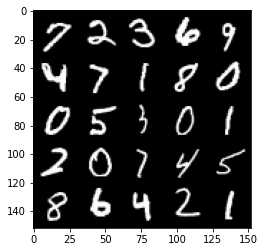

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7826786352992058, discriminator loss: 0.6653283818960193


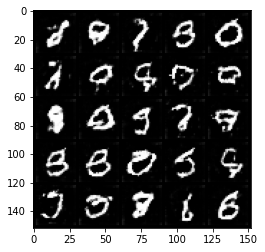

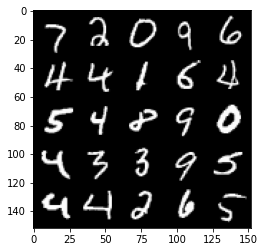

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7656097608208657, discriminator loss: 0.6727214407920833


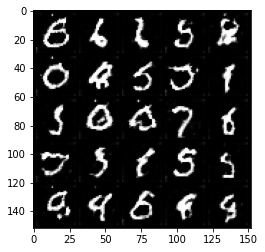

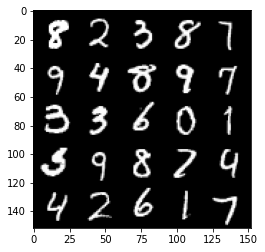

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7541824909448627, discriminator loss: 0.6756105710268021


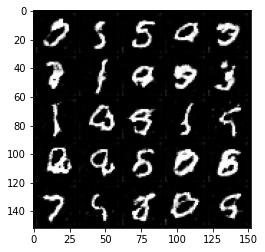

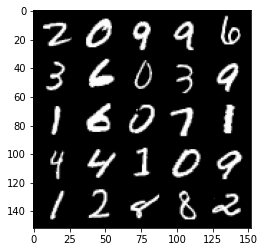

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.751540809035301, discriminator loss: 0.6795498236417774


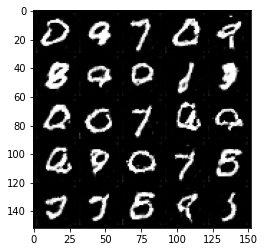

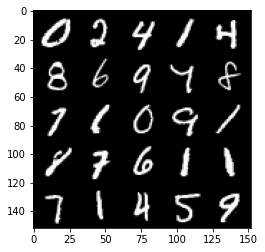

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7404644026160249, discriminator loss: 0.6852597290277482


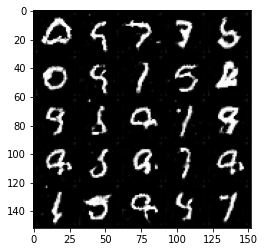

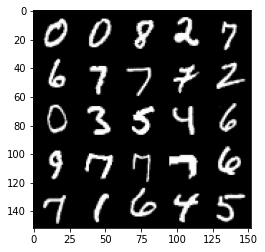

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7430044161677368, discriminator loss: 0.6889013516902927


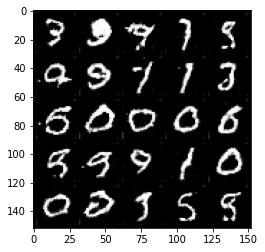

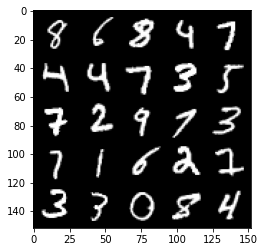

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7354595352411274, discriminator loss: 0.6894877710342412


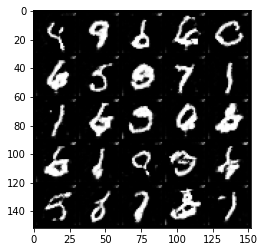

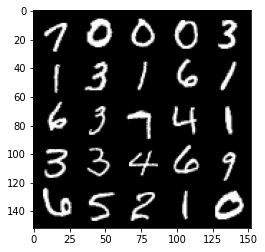

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7325227815508849, discriminator loss: 0.6900857133865358


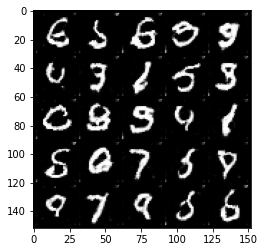

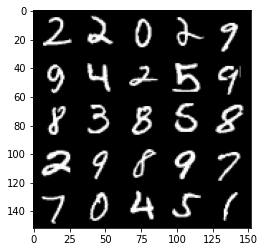

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7278280684947971, discriminator loss: 0.6911063063144686


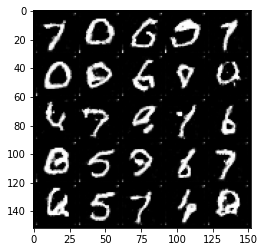

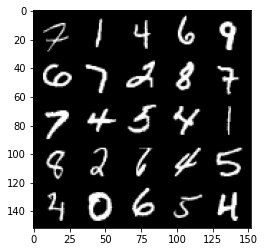

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7252529366612438, discriminator loss: 0.6928788336515428


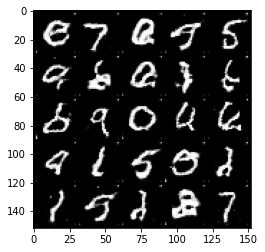

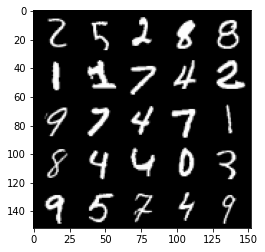

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.718241992890834, discriminator loss: 0.6943868384361264


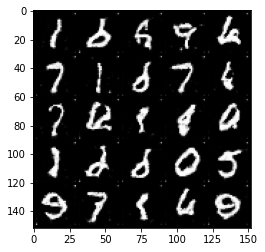

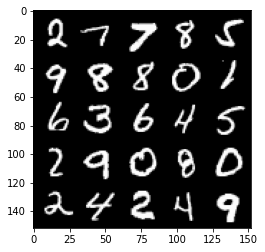

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7154405599832536, discriminator loss: 0.6965020195245752


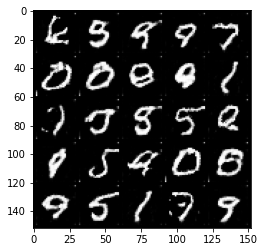

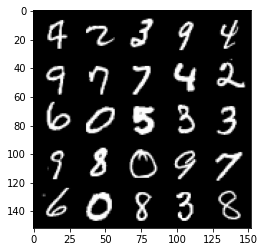

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.7147343032360077, discriminator loss: 0.6977272731065743


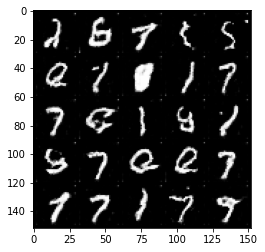

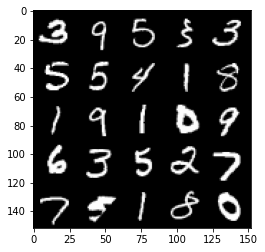

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7115408856868741, discriminator loss: 0.6984486864805223


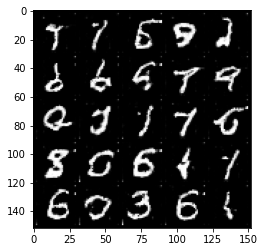

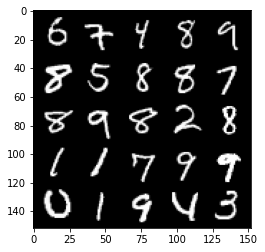

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7088042936325081, discriminator loss: 0.6988525162935254


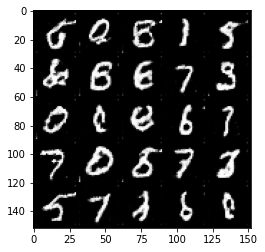

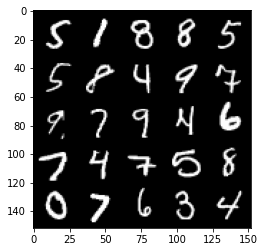

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7069525845050811, discriminator loss: 0.6982486020326609


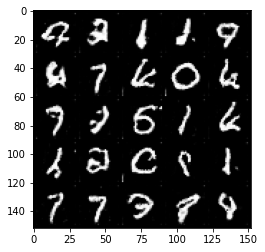

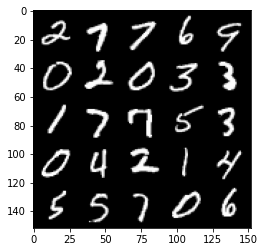

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.708514577746391, discriminator loss: 0.6980432525873186


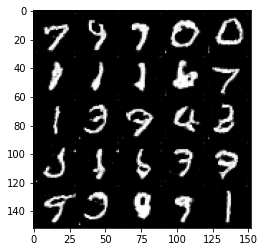

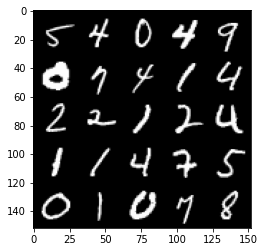

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.7058565146327024, discriminator loss: 0.6983436666727052


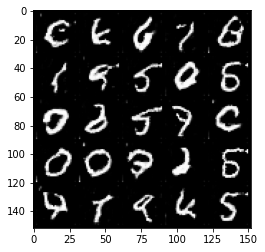

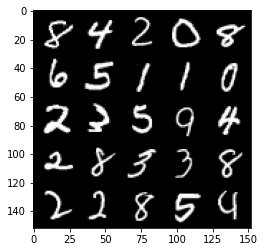

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.7047440962195395, discriminator loss: 0.6981649786233898


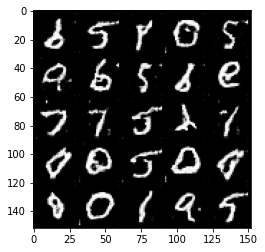

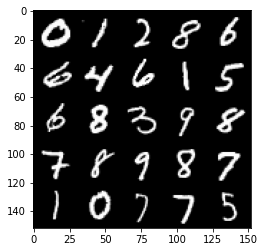

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7030368003845211, discriminator loss: 0.697500768661498


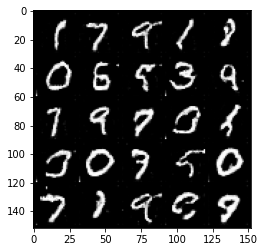

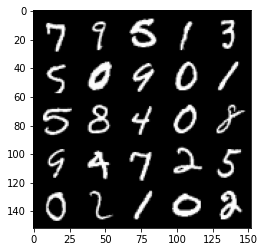

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.7051982691287997, discriminator loss: 0.6980138914585111


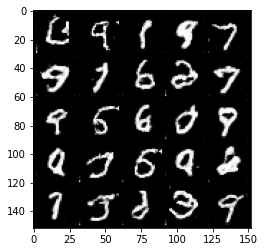

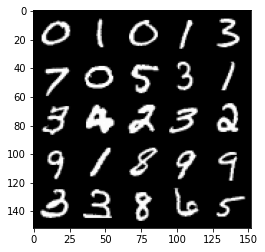

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.7027204250097271, discriminator loss: 0.697030693531036


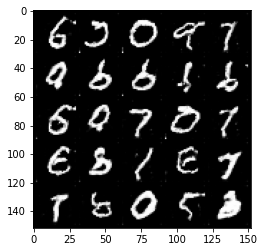

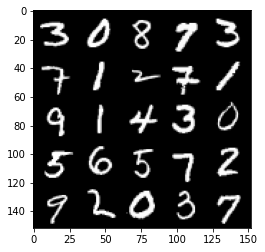

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.702637152433395, discriminator loss: 0.6975566252470021


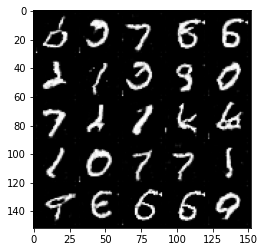

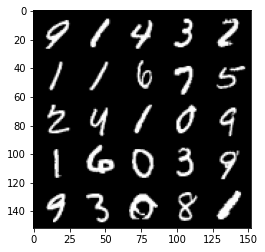

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.7039864091277126, discriminator loss: 0.6974401123523714


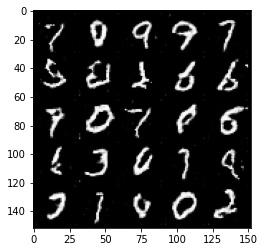

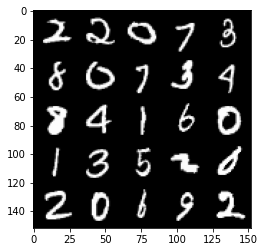

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.7020414938330646, discriminator loss: 0.697645530939102


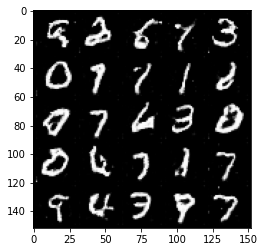

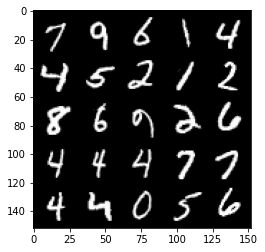

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.701608537554741, discriminator loss: 0.6971413986682885


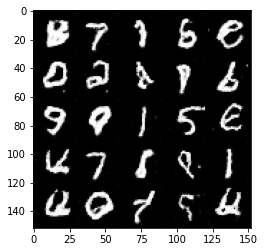

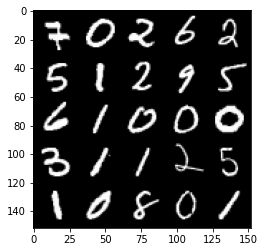

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.7000443984270098, discriminator loss: 0.6968213802576072


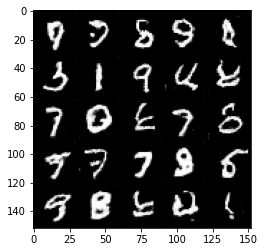

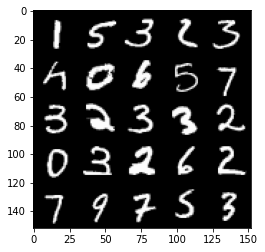

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.7021788295507437, discriminator loss: 0.696663071036339


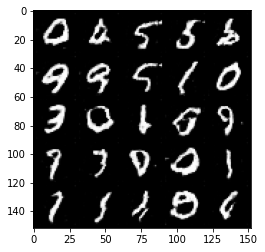

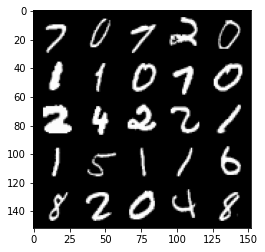

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.6999388329982751, discriminator loss: 0.6968460667133334


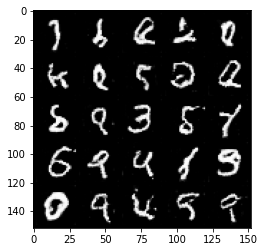

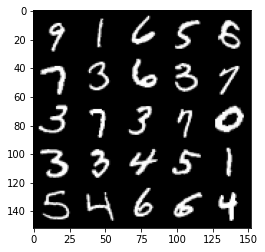

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.7004819926619539, discriminator loss: 0.6967422485351565


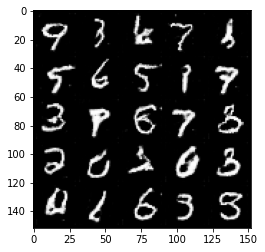

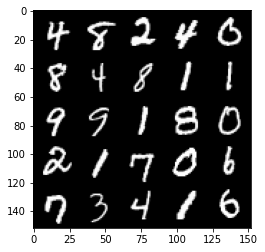

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6999338073730477, discriminator loss: 0.6965795515775679


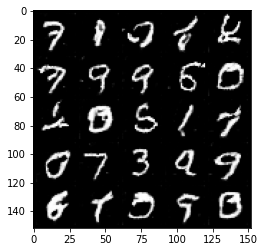

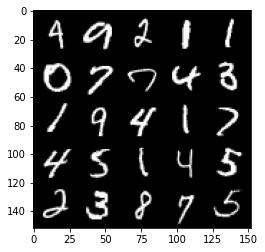

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.700845223069191, discriminator loss: 0.6968912308216094


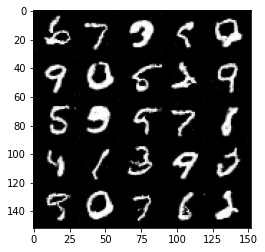

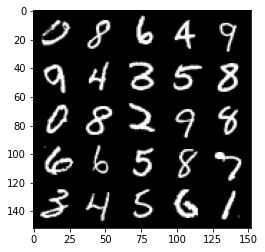

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6987099314928058, discriminator loss: 0.6963146721124653


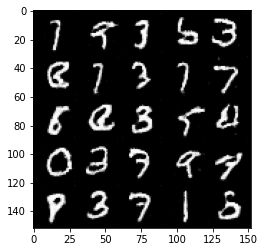

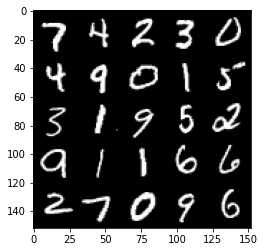

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.6982811257839197, discriminator loss: 0.6957232401371004


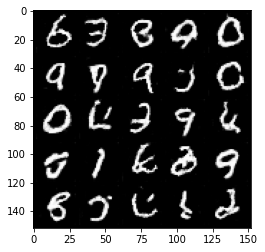

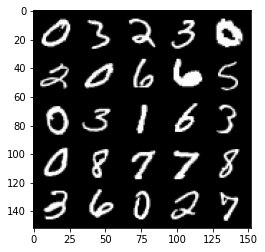

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.6982196824550632, discriminator loss: 0.6966079918146129


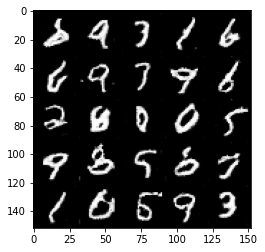

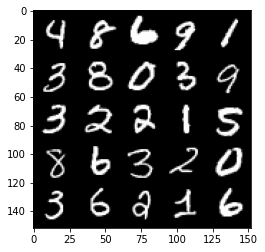

In [9]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
